<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
</center> 
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko) 

## <center> A disciplined approach to cross-validation in a Kaggle (Inclass) competition 


Here we'll show how to progress with feature engineering in the [Alice](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) competition, we'll simulate some mistakes that can be done, show how to interpret model weights with [eli5](https://github.com/TeamHG-Memex/eli5), and discuss our validation scheme even further. Prerequisites: [Alice - logistic regression baseline](https://www.kaggle.com/kashnitsky/alice-logistic-regression-baseline) and [Correct time-aware cross-validation scheme](https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme).
 
 
Plan:
 - [Submission 1: "Bag of sites" baseline](#Submission-1:-"Bag-of-sites"-baseline)
 - [Submission 2: Coming up with time features via EDA](#Submission-2:-Coming-up-with-time-features-via-EDA)
 - [Submission 3: Example of overfitting](#Submission-3:-Example-of-overfitting)
 - [Submissions 4 and 5: The importance of feature scaling](#Submissions-4-and-5:-The-importance-of-feature-scaling)
 - [Submission 6: Adding more time features](#Submission-6:-Adding-more-time-features)
 - [Submission-7: Tuning-params](#Submission-7:-Tuning-params)
 - [Analyzing submission history](#Analyzing-submission-history)
 - [Conclusions](#Conclusions)

In [10]:
# Import libraries and set desired options
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
# !pip install eli5
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html

In [11]:
PATH_TO_DATA = 'C:\\Users\\winter\\gitlab\\learn\\ods\\data\\alice\\'
SEED = 17

## Submission 1: "Bag of sites" baseline

**We'll start with basic site features, applying the "bag of words" approach. Here we read training and test sets, sort train set by session start time.**

In [12]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

**By running the above function, we get sparse train and test matrices (`X_train_sites`, `X_test_sites`), vector of train targets `y_train` (0's and 1's - whether a session belongs to Alice or not), an instance of `TfidfVectorizer` (we'll need site name from it) and site visit times both for training and test sets, for further feature engineering. Go back to the function defined above, read comments, and experiment yourself to understand what we've done here.**

In [13]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}
)

Wall time: 37.7 s


In [45]:
print(X_train_sites.shape, X_test_sites.shape)

(253561, 50000) (82797, 50000)


**These are basic features - sequences of visited web-sites.**

In [46]:
vectorizer.get_feature_names()[:10]

['0.academia-assets.com',
 '0.docs.google.com',
 '0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.docs.google.com apis.google.com',
 '0.docs.google.com 0.docs.google.com docs.google.com',
 '0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.drive.google.com 0.docs.google.com']

In [47]:
vectorizer.get_feature_names()[10000:10010]

['de-img3.ask.fm',
 'de-img4.ask.fm',
 'de.tynt.com',
 'de.tynt.com api.adyoulike.com',
 'de.tynt.com api.adyoulike.com syndication.twitter.com',
 'de.tynt.com api.adyoulike.com twitter.com',
 'de.tynt.com platform.twitter.com',
 'de.tynt.com platform.twitter.com twitter.com',
 'de.tynt.com premium.hi-mediaserver.com',
 'de.tynt.com syndication.twitter.com']

**We'll be performing time series cross-validation, see [the previous kernel](https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme) for an explanation.**

In [8]:
time_split = TimeSeriesSplit(n_splits=10)

**Perform time series cross-validation with logistic regression.**

In [49]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

In [50]:
%%time

cv_scores1 = cross_val_score(logit, X_train_sites, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 15.3 s


In [52]:
cv_scores1, cv_scores1.mean()

(array([0.83124023, 0.65993466, 0.85673565, 0.92824237, 0.84779639,
        0.88954524, 0.88829128, 0.8771044 , 0.92023038, 0.92624225]),
 0.8625362859611094)

**Train logistic regression with all training data**

In [53]:
logit.fit(X_train_sites, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Display model weights with eli5**

In [54]:
eli5.show_weights(estimator=logit, 
                  feature_names=vectorizer.get_feature_names(), top=30)

**Now we see which sites are descriptive of Alice. At the same time we notice that Alice doesn't use Gmail and Google Plus. Let's make predictions for test set and form a submission file.**

In [14]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
    
logit_test_pred = logit.predict_proba(X_test_sites)[:, 1]
write_to_submission_file(logit_test_pred, 'subm1.csv') # 0.91807

NameError: name 'logit' is not defined

In [15]:
logit_test_pred = logit.predict_proba(X_test_sites)[:, 1]
write_to_submission_file(logit_test_pred, 'subm1.csv') # 0.91807

**We are going to repeat these steps several more times. It's a nice practice to substitute repeated chunks of code with function calls. So let's write a function which performs cross-validation, model training, displaying feature importance, making predictions for a test set and forming a submission file.**

In [8]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=-1)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

NameError: name 'time_split' is not defined

In [17]:
cv_scores1 = train_and_predict(model=logit, X_train=X_train_sites, y_train=y_train, 
                  X_test=X_test_sites, site_feature_names=vectorizer.get_feature_names(),              
                  cv=time_split, submission_file_name='subm1.csv')

CV scores [0.83124023 0.65993466 0.85673565 0.92824237 0.84779639 0.88954524
 0.88829128 0.8771044  0.92023038 0.92624225]
CV mean: 0.8625362859611094, CV std: 0.07455679334182559


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +5.880
 
 
 youwatch.org
 
 
 
 
 
 
 +5.380
 
 
 cid-ed6c3e6a5c6608a4.users.storage.live.com
 
 
 
 
 
 
 +5.222
 
 
 fr.glee.wikia.com
 
 
 
 
 
 
 +5.114
 
 
 vk.com
 
 
 
 
 
 
 +4.875
 
 
 www.info-jeunes.net
 
 
 
 
 
 
 +4.499
 
 
 www.banque-chalus.fr
 
 
 
 
 
 
 +4.220
 
 
 www.express.co.uk
 
 
 
 
 
 
 +4.147
 
 
 www.audienceinsights.net
 
 
 
 
 
 
 +4.089
 
 
 www.melty.fr
 
 
 
 
 
 
 +4.003
 
 
 glee.hypnoweb.net
 
 
 
 
 
 
 +3.993
 
 
 media-1.melty.fr
 
 
 
 
 
 
 +3.945
 
 
 r4---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.917
 
 
 reviewer.lavoixdunord.fr
 
 
 
 
 
 
 +3.893
 
 
 browser-update.org
 
 
 
 
 
 
 +3.783
 
 
 r3---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.711
 
 
 api.bing.com
 
 
 
 
 
 
 +3.686
 
 
 www.kelbillet.com
 
 
 
 
 
 
 +3.596
 
 
 i1.ytimg.com
 
 
 
 
 
 
 +3.593
 
 
 dub119.mail.live.com
 
 
 
 
 
 
 +3.536
 
 
 www.video.tt
 
 
 
 
 
 
 +3.521
 
 
 www.purepeople.com
 
 
 
 
 
 
 +3.512
 
 
 www.cjn.justice.gouv.fr
 
 
 
 
 
 
 +3.511
 
 
 www.bbc.co.uk
 
 
 
 
 
 
 +3.424
 
 
 www.tete-en-lair.com
 
 
 
 
 
 
 +3.406
 
 
 www.jeux.com
 
 
 
 
 
 
 +3.373
 
 
 s.radio-canada.ca
 
 
 
 
 
 
 +3.355
 
 
 r1---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 
 … 4840 more positive … 
 
 
 

 
 
 
 … 45131 more negative … 
 
 
 
 
 
 
 -3.869
 
 
 mail.google.com
 
 
 
 
 
 
 -5.171
 
 
 plus.google.com
 
 
 
 
 
 
 -5.549
 
 
 <BIAS>

## Submission 2: Coming up with time features via EDA
Here we'll build just a few plots to motivate feature engineering. While competing, you'll need to create much more plots and build more features based on your observations. Take a look at [Kernels](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/kernels?sortBy=voteCount&group=everyone&pageSize=20&competitionId=7173) for this competition, eg. at [this "Initial EDA"](https://www.kaggle.com/adityaecdrid/initial-eda). You can do much more with sites, but let's switch to site visit times.

We've got an intuition: different people might prefer to visit (even the same) sites at *different* times of the day. Let's first draw the distribution of all session start hours. 

In [61]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

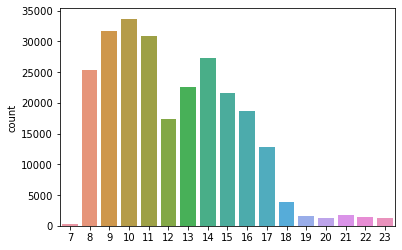

In [62]:
sns.countplot(session_start_hour);

Now the same separately for Alice and everybody else.

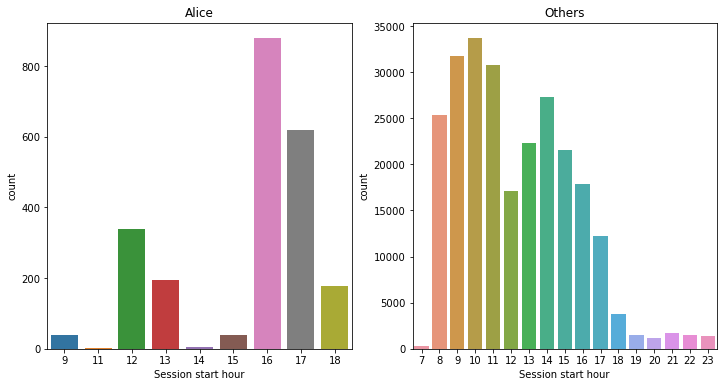

In [63]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour');

Now we definitely see that Alice mostly prefers 4-5 pm for browsing. So let's create features 'morning', 'day' and 'evening' and 'night'. Separators between these times of the day will be almost arbitrary: 0 am, 7 am, 12 am, and 7 pm. However, you can tune this.

In [59]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [60]:
pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

col_0                           0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

**Let's create a separate function to add new features (this will keep the code cleaner). To demonstrate possible overfitting, we'll keep a flag - whether to add an `hour` feature or not.**

In [71]:
def add_time_features(times, X_sparse, add_hour=True, add_month=True):
    hour = times['time1'].apply(lambda ts: ts.hour)
    month = times['time1'].apply(lambda ts: ts.month)
    
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning, day, evening, night]
    feature_names = ['morning', 'day', 'evening', 'night']
    
    if add_hour:
        # we'll do it right and scale hour dividing by 24
        objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')
        
    if add_month:
        objects_to_hstack.append(month.values.reshape(-1,1) / 12)
        feature_names.append('month')
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [72]:
%%time
X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites)
X_test_with_times1, _ = add_time_features(test_times, X_test_sites)

Wall time: 3.42 s


In [66]:
X_train_with_times1.shape, X_test_with_times1.shape

((253561, 50006), (82797, 50006))

In [ ]:
0.9167 0.062

**Performing time series cross-validation, we see an improvement in ROC AUC.**

In [73]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train_with_times1, y_train=y_train, 
                               X_test=X_test_with_times1, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm2.csv')

CV scores [0.82254118 0.78885226 0.93481128 0.96749164 0.88966864 0.96697933
 0.91662726 0.93919735 0.96660577 0.96978083]
CV mean: 0.9162555537991484, CV std: 0.06098341302741615


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +7.445
 
 
 hour
 
 
 
 
 
 
 +5.197
 
 
 cid-ed6c3e6a5c6608a4.users.storage.live.com
 
 
 
 
 
 
 +5.158
 
 
 youwatch.org
 
 
 
 
 
 
 +5.059
 
 
 www.info-jeunes.net
 
 
 
 
 
 
 +4.995
 
 
 www.express.co.uk
 
 
 
 
 
 
 +4.899
 
 
 vk.com
 
 
 
 
 
 
 +4.637
 
 
 www.melty.fr
 
 
 
 
 
 
 +4.519
 
 
 fr.glee.wikia.com
 
 
 
 
 
 
 +4.317
 
 
 www.audienceinsights.net
 
 
 
 
 
 
 +3.915
 
 
 www.banque-chalus.fr
 
 
 
 
 
 
 +3.763
 
 
 www.kelbillet.com
 
 
 
 
 
 
 +3.636
 
 
 dub119.mail.live.com
 
 
 
 
 
 
 +3.636
 
 
 api.bing.com
 
 
 
 
 
 
 +3.620
 
 
 s.videostep.com
 
 
 
 
 
 
 +3.600
 
 
 www.tete-en-lair.com
 
 
 
 
 
 
 +3.586
 
 
 media-1.melty.fr
 
 
 
 
 
 
 +3.523
 
 
 i1.ytimg.com
 
 
 
 
 
 
 +3.520
 
 
 r4---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.484
 
 
 www.purepeople.com
 
 
 
 
 
 
 +3.459
 
 
 reviewer.lavoixdunord.fr
 
 
 
 
 
 
 +3.433
 
 
 www.clermont-filmfest.com
 
 
 
 
 
 
 +3.387
 
 
 glee.hypnoweb.net
 
 
 
 
 
 
 +3.326
 
 
 static.weezbe.com
 
 
 
 
 
 
 +3.282
 
 
 browser-update.org
 
 
 
 
 
 
 +3.191
 
 
 www.jeux.com
 
 
 
 
 
 
 +3.155
 
 
 www.regarder-film-gratuit.com
 
 
 
 
 
 
 
 … 4835 more positive … 
 
 
 

 
 
 
 … 45141 more negative … 
 
 
 
 
 
 
 -4.531
 
 
 mail.google.com
 
 
 
 
 
 
 -5.441
 
 
 evening
 
 
 
 
 
 
 -5.657
 
 
 plus.google.com
 
 
 
 
 
 
 -9.214
 
 
 <BIAS>

New feature weights:
   feature      coef
0  morning -2.984572
1      day -0.788685
2  evening -5.441019
3    night  0.000000
4     hour  7.444985
5    month  1.237832


**We see an improvement almost for all folds as compared to the results of previous cross-validation.**

In [27]:
cv_scores2 > cv_scores1

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Submission 3: Example of overfitting

**Making a new submission, we notice a leaderboard score improvement as well (0.91807 ->  0.93089). Looks good as compared to sites only. But we might be a bit wary that feature `hour` gets such a big weight. Let's try the same features but without `hour`.**

In [75]:
%%time
X_train_with_times2, new_feat_names = add_time_features(train_times, X_train_sites, 
                                                        add_hour=False, add_month=False)
X_test_with_times2, _ = add_time_features(test_times, X_test_sites, 
                                          add_hour=False, add_month=False)


cv_scores3 = train_and_predict(model=logit, X_train=X_train_with_times2, y_train=y_train, 
                               X_test=X_test_with_times2, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm3.csv')


CV scores [0.88170019 0.81426901 0.91861447 0.96171465 0.91533019 0.95227476
 0.92804771 0.94016178 0.94665449 0.95277436]
CV mean: 0.9211541597021163, CV std: 0.04206421153022573


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +5.218
 
 
 youwatch.org
 
 
 
 
 
 
 +5.093
 
 
 cid-ed6c3e6a5c6608a4.users.storage.live.com
 
 
 
 
 
 
 +4.971
 
 
 www.express.co.uk
 
 
 
 
 
 
 +4.914
 
 
 vk.com
 
 
 
 
 
 
 +4.640
 
 
 fr.glee.wikia.com
 
 
 
 
 
 
 +4.542
 
 
 www.info-jeunes.net
 
 
 
 
 
 
 +4.382
 
 
 www.melty.fr
 
 
 
 
 
 
 +4.183
 
 
 www.audienceinsights.net
 
 
 
 
 
 
 +4.104
 
 
 www.banque-chalus.fr
 
 
 
 
 
 
 +3.823
 
 
 r4---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.663
 
 
 glee.hypnoweb.net
 
 
 
 
 
 
 +3.615
 
 
 www.kelbillet.com
 
 
 
 
 
 
 +3.594
 
 
 api.bing.com
 
 
 
 
 
 
 +3.589
 
 
 browser-update.org
 
 
 
 
 
 
 +3.570
 
 
 i1.ytimg.com
 
 
 
 
 
 
 +3.559
 
 
 media-1.melty.fr
 
 
 
 
 
 
 +3.546
 
 
 s.videostep.com
 
 
 
 
 
 
 +3.527
 
 
 reviewer.lavoixdunord.fr
 
 
 
 
 
 
 +3.484
 
 
 dub119.mail.live.com
 
 
 
 
 
 
 +3.453
 
 
 www.jeux.com
 
 
 
 
 
 
 +3.384
 
 
 r3---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.354
 
 
 r1---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.335
 
 
 www.demotivateur.fr
 
 
 
 
 
 
 +3.210
 
 
 www.regarder-film-gratuit.com
 
 
 
 
 
 
 +3.192
 
 
 www.cjn.justice.gouv.fr
 
 
 
 
 
 
 +3.156
 
 
 www35.glam.com
 
 
 
 
 
 
 
 … 4829 more positive … 
 
 
 

 
 
 
 … 45145 more negative … 
 
 
 
 
 
 
 -3.212
 
 
 morning
 
 
 
 
 
 
 -4.291
 
 
 mail.google.com
 
 
 
 
 
 
 -5.390
 
 
 plus.google.com
 
 
 
 
 
 
 -5.407
 
 
 <BIAS>

New feature weights:
   feature      coef
0  morning -3.211819
1      day  0.526636
2  evening -2.721465
3    night  0.000000
Wall time: 24.5 s


**Now cross-validation is much more stable. 3rd CV results are better for each and every fold as compared to the first ones. And actually the situation is better than with the `hour` feature for 5 folds out of 10, but in such case we'll prefer a model with less variation of CV results, i.e. the last one.**

In [76]:
cv_scores3 > cv_scores1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [77]:
cv_scores3 > cv_scores2

array([ True,  True, False, False,  True, False,  True,  True, False,
       False])

Making a new submission we get... Wow! **0.94535** Public LB score instead of **0.93089** when adding the `hour` feature. We were right, the `hour` feature leads to overfitting, and it's better not to add it. 

## Submissions 4 and 5: The importance of feature scaling

**Now we'll add a new feature: session duration. But beware: first we'll do it in an incorrect way, then we'll correct ourselves.**

In [6]:
def add_session_duration_incorrect(times, X_sparse):
    new_feat = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[ms]').astype(int)
    return hstack([X_sparse, new_feat.values.reshape(-1, 1)])

In [79]:
X_train_with_time_incorrect = add_session_duration_incorrect(train_times, X_train_with_times2)
X_test_with_time_incorrect = add_session_duration_incorrect(test_times, X_test_with_times2)

In [80]:
cv_scores4 = train_and_predict(model=logit, X_train=X_train_with_time_incorrect, y_train=y_train, 
                               X_test=X_test_with_time_incorrect, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm4.csv')

CV scores [0.57324417 0.6057354  0.59064502 0.55137641 0.63484782 0.66004053
 0.74572105 0.67174803 0.61461151 0.61200149]
CV mean: 0.6259971432088414, CV std: 0.05291615658123371


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 
 … 1784 more positive … 
 
 
 

 
 
 
 … 48191 more negative … 
 
 
 
 
 
 
 -0.009
 
 
 khms1.google.fr
 
 
 
 
 
 
 -0.009
 
 
 ts2.mm.bing.net
 
 
 
 
 
 
 -0.010
 
 
 s.ytimg.com
 
 
 
 
 
 
 -0.010
 
 
 www.youtube.com
 
 
 
 
 
 
 -0.010
 
 
 mail.google.com
 
 
 
 
 
 
 -0.011
 
 
 clients1.google.com
 
 
 
 
 
 
 -0.012
 
 
 mts1.google.com
 
 
 
 
 
 
 -0.012
 
 
 ajax.googleapis.com
 
 
 
 
 
 
 -0.012
 
 
 twitter.com
 
 
 
 
 
 
 -0.012
 
 
 mts0.google.com
 
 
 
 
 
 
 -0.014
 
 
 accounts.google.com
 
 
 
 
 
 
 -0.015
 
 
 ts1.mm.bing.net
 
 
 
 
 
 
 -0.015
 
 
 connect.facebook.net
 
 
 
 
 
 
 -0.019
 
 
 www.google.fr
 
 
 
 
 
 
 -0.021
 
 
 s-static.ak.facebook.com
 
 
 
 
 
 
 -0.022
 
 
 static.ak.facebook.com
 
 
 
 
 
 
 -0.023
 
 
 www.bing.com
 
 
 
 
 
 
 -0.024
 
 
 apis.google.com
 
 
 
 
 
 
 -0.025
 
 
 www.google.com
 
 
 
 
 
 
 -0.026
 
 
 platform.twitter.com
 
 
 
 
 
 
 -0.038
 
 
 www.facebook.com
 
 
 
 
 
 
 -0.044
 
 
 unknown unknown unknown unknown unknown
 
 
 
 
 
 
 -0.045
 
 
 evening
 
 
 
 
 
 
 -0.054
 
 
 unknown unknown unknown unknown
 
 
 
 
 
 
 -0.065
 
 
 unknown unknown unknown
 
 
 
 
 
 
 -0.075
 
 
 unknown unknown
 
 
 
 
 
 
 -0.084
 
 
 unknown
 
 
 
 
 
 
 -0.603
 
 
 day
 
 
 
 
 
 
 -0.690
 
 
 morning
 
 
 
 
 
 
 -1.337
 
 
 <BIAS>

New feature weights:
         feature      coef
0        morning -0.689711
1            day -0.602607
2        evening -0.045053
3          night  0.000000
4  sess_duration -0.000044


**What's the reason of such a deterioration?**
Obvious! The new feature is session duration in milliseconds, it's maximal value is very high (check it). We need to either scale a new feature or, alternatively, measure it in some different units. You can check that actually, measuring it in seconds (rather than milliseconds will do). But instead we'll perform feature scaling, it's a more universal technique to apply for numeric features which can take high values.

In [81]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

In [82]:
X_train_with_time_correct = hstack([X_train_with_times2, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times2, test_dur_scaled])

In [83]:
cv_scores5 = train_and_predict(model=logit, X_train=X_train_with_time_correct, y_train=y_train, 
                               X_test=X_test_with_time_correct, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm5.csv')

CV scores [0.86809822 0.81821851 0.91950143 0.96171682 0.91593618 0.95368912
 0.93027726 0.94128874 0.94847477 0.95287352]
CV mean: 0.9210074562651493, CV std: 0.04287824906593912


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +5.212
 
 
 youwatch.org
 
 
 
 
 
 
 +5.058
 
 
 cid-ed6c3e6a5c6608a4.users.storage.live.com
 
 
 
 
 
 
 +4.975
 
 
 vk.com
 
 
 
 
 
 
 +4.970
 
 
 www.express.co.uk
 
 
 
 
 
 
 +4.617
 
 
 fr.glee.wikia.com
 
 
 
 
 
 
 +4.531
 
 
 www.info-jeunes.net
 
 
 
 
 
 
 +4.363
 
 
 www.melty.fr
 
 
 
 
 
 
 +4.149
 
 
 www.banque-chalus.fr
 
 
 
 
 
 
 +4.146
 
 
 www.audienceinsights.net
 
 
 
 
 
 
 +3.792
 
 
 r4---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.694
 
 
 api.bing.com
 
 
 
 
 
 
 +3.632
 
 
 glee.hypnoweb.net
 
 
 
 
 
 
 +3.586
 
 
 www.kelbillet.com
 
 
 
 
 
 
 +3.570
 
 
 browser-update.org
 
 
 
 
 
 
 +3.546
 
 
 media-1.melty.fr
 
 
 
 
 
 
 +3.543
 
 
 i1.ytimg.com
 
 
 
 
 
 
 +3.517
 
 
 s.videostep.com
 
 
 
 
 
 
 +3.499
 
 
 reviewer.lavoixdunord.fr
 
 
 
 
 
 
 +3.497
 
 
 dub119.mail.live.com
 
 
 
 
 
 
 +3.435
 
 
 www.jeux.com
 
 
 
 
 
 
 +3.351
 
 
 r3---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.331
 
 
 r1---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.321
 
 
 www.demotivateur.fr
 
 
 
 
 
 
 +3.248
 
 
 www.video.tt
 
 
 
 
 
 
 +3.181
 
 
 www.cjn.justice.gouv.fr
 
 
 
 
 
 
 +3.161
 
 
 www.regarder-film-gratuit.com
 
 
 
 
 
 
 
 … 4830 more positive … 
 
 
 

 
 
 
 … 45145 more negative … 
 
 
 
 
 
 
 -3.231
 
 
 morning
 
 
 
 
 
 
 -4.192
 
 
 mail.google.com
 
 
 
 
 
 
 -5.284
 
 
 plus.google.com
 
 
 
 
 
 
 -5.444
 
 
 <BIAS>

New feature weights:
         feature      coef
0        morning -3.230512
1            day  0.509502
2        evening -2.722768
3          night  0.000000
4  sess_duration -0.241722


**New model predicts better on 9 folds out of 10 as compared to the model with sites and time features. Submitting yields 0.94630 Public LB ROC AUC.**

In [37]:
cv_scores5 > cv_scores3

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Submission 6: Adding more time features

In a real competition it's very important to keep track of Public Kernels and borrow some ideas form them.  For instance, we can explore [this Kernel](https://www.kaggle.com/hakeydotcom/additional-time-features-and-logit) and decide to add to features: day of week and month. In this case it's easy to come up to such features on your own, but still typically there's a lot to find out in Kernels.  

In [51]:
train_times.head()

time1               time2               time3  \
session_id                                                               
21669      2013-01-12 08:05:57 2013-01-12 08:05:57                 NaT   
54843      2013-01-12 08:37:23 2013-01-12 08:37:23 2013-01-12 09:07:07   
77292      2013-01-12 08:50:13 2013-01-12 08:50:14 2013-01-12 08:50:15   
114021     2013-01-12 08:50:17 2013-01-12 08:50:17 2013-01-12 08:50:18   
146670     2013-01-12 08:50:20 2013-01-12 08:50:20 2013-01-12 08:50:20   

                         time4               time5               time6  \
session_id                                                               
21669                      NaT                 NaT                 NaT   
54843      2013-01-12 09:07:09                 NaT                 NaT   
77292      2013-01-12 08:50:15 2013-01-12 08:50:16 2013-01-12 08:50:16   
114021     2013-01-12 08:50:18 2013-01-12 08:50:18 2013-01-12 08:50:18   
146670     2013-01-12 08:50:21 2013-01-12 08:50:21 2013-01-12 08:50:21   

                         time7               time8               time9  \
session_id                                                               
21669                      NaT                 NaT                 NaT   
54843                      NaT                 NaT                 NaT   
77292      2013-01-12 08:50:16 2013-01-12 08:50:16 2013-01-12 08:50:17   
114021     2013-01-12 08:50:19 2013-01-12 08:50:19 2013-01-12 08:50:19   
146670     2013-01-12 08:50:21 2013-01-12 08:50:22 2013-01-12 08:50:22   

                        time10  
session_id                      
21669                      NaT  
54843                      NaT  
77292      2013-01-12 08:50:17  
114021     2013-01-12 08:50:20  
146670     2013-01-12 08:50:22

In [85]:
def add_day_month(times, X_sparse):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5

    objects_to_hstack = [X_sparse, day_of_week, month, year_month]
    feature_names = ['day_of_week', 'month', 'year_month']
    train_df[sites].isna().sum(axis=1)    
    X = hstack(objects_to_hstack)
    return X, feature_names

In [86]:
X_train_final, more_feat_names = add_day_month(train_times, X_train_with_time_correct)
X_test_final, _ = add_day_month(test_times, X_test_with_time_correct)

In [102]:
cv_scores6 = train_and_predict(model=logit, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm6.csv')

CV scores [0.76714843 0.81597079 0.90540725 0.96307368 0.91634775 0.95852658
 0.92722248 0.95188156 0.95890711 0.96919612]
CV mean: 0.9133681759819172, CV std: 0.06504953159343752


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +5.163
 
 
 youwatch.org
 
 
 
 
 
 
 +5.039
 
 
 vk.com
 
 
 
 
 
 
 +5.011
 
 
 www.express.co.uk
 
 
 
 
 
 
 +4.985
 
 
 cid-ed6c3e6a5c6608a4.users.storage.live.com
 
 
 
 
 
 
 +4.689
 
 
 www.info-jeunes.net
 
 
 
 
 
 
 +4.441
 
 
 www.melty.fr
 
 
 
 
 
 
 +4.387
 
 
 fr.glee.wikia.com
 
 
 
 
 
 
 +4.335
 
 
 www.audienceinsights.net
 
 
 
 
 
 
 +4.021
 
 
 www.banque-chalus.fr
 
 
 
 
 
 
 +3.963
 
 
 api.bing.com
 
 
 
 
 
 
 +3.765
 
 
 r4---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.705
 
 
 i1.ytimg.com
 
 
 
 
 
 
 +3.608
 
 
 www.kelbillet.com
 
 
 
 
 
 
 +3.584
 
 
 s.videostep.com
 
 
 
 
 
 
 +3.571
 
 
 dub119.mail.live.com
 
 
 
 
 
 
 +3.515
 
 
 media-1.melty.fr
 
 
 
 
 
 
 +3.431
 
 
 browser-update.org
 
 
 
 
 
 
 +3.381
 
 
 glee.hypnoweb.net
 
 
 
 
 
 
 +3.379
 
 
 www.video.tt
 
 
 
 
 
 
 +3.300
 
 
 www.jeux.com
 
 
 
 
 
 
 +3.237
 
 
 reviewer.lavoixdunord.fr
 
 
 
 
 
 
 +3.193
 
 
 r3---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +3.190
 
 
 www.demotivateur.fr
 
 
 
 
 
 
 +3.167
 
 
 dub128.mail.live.com
 
 
 
 
 
 
 +3.115
 
 
 s.radio-canada.ca
 
 
 
 
 
 
 +3.082
 
 
 www.tete-en-lair.com
 
 
 
 
 
 
 +3.064
 
 
 www.caf.fr
 
 
 
 
 
 
 +3.054
 
 
 www.clermont-filmfest.com
 
 
 
 
 
 
 
 … 4810 more positive … 
 
 
 

 
 
 
 … 45168 more negative … 
 
 
 
 
 
 
 -4.213
 
 
 mail.google.com
 
 
 
 
 
 
 -5.399
 
 
 plus.google.com

New feature weights:
         feature      coef
0        morning -1.660450
1            day  2.059678
2        evening -1.737744
3          night  0.000000
4  sess_duration -0.262805
5    day_of_week -0.367643
6          month  0.108568
7     year_month -2.754056


## Submission 7: Tuning params
When you're done with feature engineering (no more ideas) you can tune hyperparameters in your model. Typically, at this point you create nice code for your pipeline, and then tune various params for a long time. Here we used several params - `ngram_range`, `max_features`. Choosing between `CountVectorizer` and `TfIdfVectorizer` might also be treated as a hyperparameter. But now we'll tune only regularization strength `C`.

In [345]:
# here we've already narrowed down c_values to such a range.
# typically, you would start with a wider range of values to check
c_values = np.logspace(-2, 2, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [346]:
%%time
logit_grid_searcher.fit(X_train_final, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.6min finished


Wall time: 15min 56s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='wa...
             param_grid={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+0

In [347]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9210358519282063, {'C': 3.359818286283781})

In [49]:
# OLD
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9164733150672555, {'C': 3.359818286283781})

In [96]:
%%time
C = 3.359818286283781
param_grid = [
  {'penalty': ['l1'], 'solver': [ 'lbfgs', 'liblinear', 'sag', 'saga']},
  {'penalty': ['l2'], 'solver': ['newton-cg']},
  {'penalty': ['saga'], 'solver': ['elasticnet']}
 ]
logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C':[C], 'penalty':penalty},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

logit_grid_searcher.fit(X_train_final, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.4min finished


Wall time: 7min 38s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [3.359818286283781], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [98]:
logit_grid_searcher.best_params_

{'C': 3.359818286283781, 'penalty': 'l2'}

In [106]:
cv_scores7 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm8.csv')

CV scores [0.78590509 0.8006631  0.91498106 0.96944336 0.91975221 0.95615006
 0.9413044  0.94704704 0.96257521 0.96691162]
CV mean: 0.9164733150672554, CV std: 0.06408888998138046


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +11.062
 
 
 www.express.co.uk
 
 
 
 
 
 
 +9.801
 
 
 cid-ed6c3e6a5c6608a4.users.storage.live.com
 
 
 
 
 
 
 +7.008
 
 
 tru.am
 
 
 
 
 
 
 +6.372
 
 
 browser-update.org
 
 
 
 
 
 
 +6.013
 
 
 fr.glee.wikia.com
 
 
 
 
 
 
 +5.800
 
 
 api.bing.com
 
 
 
 
 
 
 +5.777
 
 
 www.banque-chalus.fr
 
 
 
 
 
 
 +5.646
 
 
 youwatch.org
 
 
 
 
 
 
 +5.501
 
 
 vk.com
 
 
 
 
 
 
 +5.401
 
 
 glee.hypnoweb.net
 
 
 
 
 
 
 +5.368
 
 
 www.info-jeunes.net
 
 
 
 
 
 
 +5.210
 
 
 www.kelbillet.com
 
 
 
 
 
 
 +5.187
 
 
 www.video.tt
 
 
 
 
 
 
 +5.179
 
 
 www.jeux.com
 
 
 
 
 
 
 +5.156
 
 
 mcetv.fr
 
 
 
 
 
 
 +5.111
 
 
 www.melty.fr
 
 
 
 
 
 
 +5.106
 
 
 s.radio-canada.ca
 
 
 
 
 
 
 +5.064
 
 
 media-1.melty.fr
 
 
 
 
 
 
 +4.999
 
 
 www.clermont-filmfest.com
 
 
 
 
 
 
 +4.998
 
 
 www.springboardplatform.com
 
 
 
 
 
 
 +4.970
 
 
 s.videostep.com
 
 
 
 
 
 
 +4.924
 
 
 dub119.mail.live.com
 
 
 
 
 
 
 +4.829
 
 
 www.tete-en-lair.com
 
 
 
 
 
 
 +4.821
 
 
 www.regarder-film-gratuit.com
 
 
 
 
 
 
 +4.821
 
 
 www.audienceinsights.net
 
 
 
 
 
 
 +4.742
 
 
 r4---sn-gxo5uxg-jqbe.googlevideo.com
 
 
 
 
 
 
 +4.727
 
 
 www.rhonealpesjob.com
 
 
 
 
 
 
 +4.625
 
 
 demotivateur.disqus.com
 
 
 
 
 
 
 
 … 4753 more positive … 
 
 
 

 
 
 
 … 45225 more negative … 
 
 
 
 
 
 
 -6.843
 
 
 mail.google.com
 
 
 
 
 
 
 -9.227
 
 
 plus.google.com

New feature weights:
         feature      coef
0        morning -1.482447
1            day  2.337111
2        evening -2.330715
3          night  0.000000
4  sess_duration -0.210983
5    day_of_week -0.372646
6          month  0.124806
7     year_month -3.164223


Here tuning params helps only for 6 folds out of 10. Typically in such situation you'll make one more submission to compare LB scores as well. 0.94954 - it's less than without hyperparameter tuning. **Bad news in the end:** our CV scheme is not perfect. Try  to improve it! (*hint:* is all training set needed for a good prediction?). 

In [266]:
cv_scores10 > cv_scores8

array([False,  True,  True,  True,  True,  True,  True, False,  True,
        True])

## Analyzing submission history
Let's summarize CV results and LB scores for all 7 submissions:

In [107]:
cv_means = [np.round(cv_scores.mean(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3,
                                                                 cv_scores4, cv_scores5, cv_scores6, cv_scores7]]
cv_stds = [np.round(cv_scores.std(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3,
                                                                 cv_scores4, cv_scores5, cv_scores6, cv_scores7]]
public_lb_scores = [0.91807, 0.93135, 0.94526, 0.67016, 0.94620, 0.95061, 0.95055]

subm_df = pd.DataFrame({'CV_mean': cv_means, 'CV_std': cv_stds, 'LB': public_lb_scores},
                      index=range(1, len(cv_means) + 1))
subm_df

CV_mean   CV_std       LB
1  0.86254  0.07456  0.91807
2  0.91626  0.06098  0.93135
3  0.92115  0.04206  0.94526
4  0.62600  0.05292  0.67016
5  0.92101  0.04288  0.94620
6  0.91337  0.06505  0.95061
7  0.91647  0.06409  0.95055

The correlation between CV mean and LB exists, but it's not perfect. So which submission to choose in the end? A popular method is to treat mean CV and LB results with weights, proportional to train and test sizes. However, considering time, we'll trust public LB score more and set it's weight to 0.6 (no theory here, only practical experience). Also, as we've seen, standard deviation of CV results is also important, so you can experiment here. 

In [112]:
subm_df['cv_lb_weighted'] =  0.6 * subm_df['LB'] + (1 - 0.6) * subm_df['CV_mean']
subm_df

CV_mean   CV_std       LB  cv_lb_weighted
1  0.86254  0.07456  0.91807        0.895858
2  0.91626  0.06098  0.93135        0.925314
3  0.92115  0.04206  0.94526        0.935616
4  0.62600  0.05292  0.67016        0.652496
5  0.92101  0.04288  0.94620        0.936124
6  0.91337  0.06505  0.95061        0.935714
7  0.91647  0.06409  0.95055        0.936918

In [ ]:
# so we'll treat the last submission as the best one
!cp subm7.csv submission.csv

## Conclusions
 - keep track of cross-validation improvements for *each* fold (or at least as many folds as possible)
 - take a look at cross-validation std, not only mean
 - try to build a CV scheme so that CV improvements correlate with LB improvements (it's very important)
 - exploring feature importance might help, sometimes even in detecting overfitting
 - spend most of the competition time exploring data and building features
 
Good luck!

<img src="https://habrastorage.org/webt/ai/xu/sy/aixusyqysuiou9rsll7x909jyw0.jpeg" width=50% /> 
*<div style="text-align: center"> image credit <a href='http://www.alicekristiansen.com/'>www.alicekristiansen.com</a> </div>*


In [9]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=-1)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    print(model.coef_)
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

In [16]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params) #TfidfVectorizer
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times


X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}
)

X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites)
X_test_with_times1, _ = add_time_features(test_times, X_test_sites)


X_train_with_times2, new_feat_names = add_time_features(train_times, X_train_sites, 
                                                        add_hour=False, add_month=False)
X_test_with_times2, _ = add_time_features(test_times, X_test_sites, 
                                          add_hour=False, add_month=False)


X_train_with_time_incorrect = add_session_duration_incorrect(train_times, X_train_with_times2)
X_test_with_time_incorrect = add_session_duration_incorrect(test_times, X_test_with_times2)


train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))


X_train_with_time_correct = hstack([X_train_with_times2, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times2, test_dur_scaled])

In [15]:
def add_time_features(times, X_sparse, add_hour=True, add_month=False):
    hour = times['time1'].apply(lambda ts: ts.hour)
    month = times['time1'].apply(lambda ts: ts.month)
   
    
    

    morning = ((hour >= 10) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    
    day = ((hour >= 12) & (hour <= 16)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 17) & (hour <= 20)).astype('int').values.reshape(-1, 1)

    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning, day, evening, night]
    feature_names = ['morning', 'day', 'evening', 'night']

#     objects_to_hstack = [X_sparse, morning, evening]
#     feature_names = ['morning',  'evening']
    hour = StandardScaler().fit_transform(hour.values.reshape(-1,1))
    month = StandardScaler().fit_transform(month.values.reshape(-1, 1))
    
    if add_hour:
        # we'll do it right and scale hour dividing by 24
        objects_to_hstack.append(hour)
        feature_names.append('hour')
        
    if add_month:
        objects_to_hstack.append(month )
        feature_names.append('month')
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [14]:
def add_day_month(times, X_sparse):
    
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
#     month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1)
#     month = StandardScaler().fit_transform(month)

    isna = StandardScaler().fit_transform(times.isna().sum(axis=1).values.reshape(-1, 1))
#     hour = times['time1'].apply(lambda ts: ts.hour)
#     hour_dw = StandardScaler().fit_transform((hour + times['time1'].apply(
#                                              lambda t: t.weekday())).values.reshape(-1,1))
    day_of_week = StandardScaler().fit_transform(day_of_week)
    
   
    
    
    sess_dur = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[ms]').astype(int)
    
#     dw_sess = 1000 *  times['time1'].apply(lambda t: t.weekday()) + sess_dur
#     dw_sess = StandardScaler().fit_transform(dw_sess.values.reshape(-1,1))
    
    # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month)
    year_month = StandardScaler().fit_transform(year_month.values.reshape(-1, 1))
    
    objects_to_hstack = [X_sparse, day_of_week, year_month, isna]
    feature_names = ['day_of_week', 'year_month', 'isna']
       
    X = hstack(objects_to_hstack)
    return X, feature_names

In [18]:
X_train_final, more_feat_names = add_day_month(train_times, X_train_with_time_correct)
X_test_final, _ = add_day_month(test_times, X_test_with_time_correct)

In [123]:
time_split_2 = TimeSeriesSplit(n_splits=10)

In [19]:
final_model = LogisticRegression(C=3.359818286283781, 
                                 max_iter=1000, n_jobs=-1)

final_model.fit(X_train_final, y_train)

C:\Users\winter\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\winter\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=3.359818286283781, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [251]:
CV scores [0.84063343 0.80192364 0.94993238 0.96934784 0.92115336 0.95837711
 0.9358222  0.9489216  0.96206269 0.96820589]
CV mean: 0.9256380137820894, CV std: 0.05468854833697953

In [2]:
from catboost import CatBoostClassifier
ctb = CatBoostClassifier(iterations=1000, task_type="GPU", devices='1',random_seed=SEED)
ctb.fit(X_train_final, y_train, verbose=100)

NameError: name 'SEED' is not defined

In [1]:
roc_auc_score(y_train, ctb.predict(X_train_final))

NameError: name 'roc_auc_score' is not defined

In [50]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(max_depth=25,random_state=SEED)
model_xgb.fit(X_train_final, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [51]:
roc_auc_score(y_train, model_xgb.predict(X_train_final))


0.9521114497170222

In [42]:
# from sklearn.naive_bayes import GaussianNB

# gnb = GaussianNB()
# gnb.fit(X_train_final, y_train)
# roc_auc_score(y_train, gnb.predict(X_train_final))

In [37]:
from sklearn.svm import LinearSVC, SVC

lsvc = SVC(random_state=SEED, probability=True)
lsvc.fit(X_train_final, y_train)

C:\Users\winter\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=17,
    shrinking=True, tol=0.001, verbose=False)

In [38]:
roc_auc_score(y_train, lsvc.predict(X_train_final))

0.5

In [55]:
time_split_2 = TimeSeriesSplit(n_splits=3)
cv_scores_new = train_and_predict(model=model_xgb, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv= time_split_2, submission_file_name='subm9.csv')

CV scores [0.82883249 0.93799468 0.92294673]
CV mean: 0.8965913018273074, CV std: 0.04830495040757169


AttributeError: Coefficients are not defined for Booster type gbtree

In [ ]:
CV scores_last [0.84063343 0.80192364 0.94993238 0.96934784 0.92115336 0.95837711
 0.9358222  0.9489216  0.96206269 0.96820589]
CV mean: 0.9256380137820894, CV std: 0.05468854833697953

In [11]:
cv_scores_new = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=5, submission_file_name='subm9.csv')

NameError: name 'final_model' is not defined

In [342]:
cv_scores_last = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split_2, submission_file_name='subm9.csv')

CV scores [0.77352885 0.8149141  0.96346071 0.96855543 0.92277652 0.95708107
 0.92473232 0.94476034 0.96778377 0.97276541]
CV mean: 0.9210358519282063, CV std: 0.06619534458116959
[[-0.0268648   1.24596781 -0.34216097 ... -0.59352767 -0.55939956
  -0.71614891]]


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +10.301
 
 
 cid-ed6c3e6a5c6608a4.users.storage.live.com
 
 
 
 
 
 
 +9.551
 
 
 www.express.co.uk
 
 
 
 
 
 
 +6.686
 
 
 tru.am
 
 
 
 
 
 
 +6.018
 
 
 fr.glee.wikia.com
 
 
 
 
 
 
 +5.922
 
 
 browser-update.org
 
 
 
 
 
 
 +5.862
 
 
 www.banque-chalus.fr
 
 
 
 
 
 
 +5.649
 
 
 api.bing.com
 
 
 
 
 
 
 +5.629
 
 
 www.kelbillet.com
 
 
 
 
 
 
 +5.604
 
 
 www.info-jeunes.net
 
 
 
 
 
 
 +5.533
 
 
 mcetv.fr
 
 
 
 
 
 
 +5.327
 
 
 www.springboardplatform.com
 
 
 
 
 
 
 +5.314
 
 
 youwatch.org
 
 
 
 
 
 
 +5.312
 
 
 www.clermont-filmfest.com
 
 
 
 
 
 
 +5.309
 
 
 www.melty.fr
 
 
 
 
 
 
 +5.282
 
 
 s.radio-canada.ca
 
 
 
 
 
 
 +5.278
 
 
 media-1.melty.fr
 
 
 
 
 
 
 +5.182
 
 
 vk.com
 
 
 
 
 
 
 +5.176
 
 
 www.tete-en-lair.com
 
 
 
 
 
 
 +5.107
 
 
 www.audienceinsights.net
 
 
 
 
 
 
 +5.086
 
 
 dub119.mail.live.com
 
 
 
 
 
 
 +4.997
 
 
 s.videostep.com
 
 
 
 
 
 
 +4.868
 
 
 glee.hypnoweb.net
 
 
 
 
 
 
 +4.862
 
 
 www.regarder-film-gratuit.com
 
 
 
 
 
 
 +4.805
 
 
 demotivateur.disqus.com
 
 
 
 
 
 
 +4.775
 
 
 www.jeux.com
 
 
 
 
 
 
 +4.731
 
 
 static.weezbe.com
 
 
 
 
 
 
 +4.700
 
 
 www.jobisjob.fr
 
 
 
 
 
 
 
 … 4733 more positive … 
 
 
 

 
 
 
 … 45247 more negative … 
 
 
 
 
 
 
 -7.020
 
 
 <BIAS>
 
 
 
 
 
 
 -7.031
 
 
 mail.google.com
 
 
 
 
 
 
 -9.273
 
 
 plus.google.com

New feature weights:
         feature      coef
0        morning -4.604639
1            day  0.765600
2        evening  1.853962
3          night  0.000000
4  early_morning -2.109381
5   late_evening -2.925155
6  sess_duration -0.211512
7    day_of_week -0.593528
8     year_month -0.559400
9           isna -0.716149


In [229]:
from sklearn.neural_network import MLPClassifier


dnn = MLPClassifier(activation='relu', shuffle=False,
                    verbose=True, early_stopping=True,
                    hidden_layer_sizes=(10,),
                    random_state=SEED)
dnn.fit(X_train_final, y_train)


Iteration 1, loss = 0.19328598
Validation score: 0.990930
Iteration 2, loss = 0.04565253
Validation score: 0.990930
Iteration 3, loss = 0.03787626
Validation score: 0.990930
Iteration 4, loss = 0.03395327
Validation score: 0.990930
Iteration 5, loss = 0.03131826
Validation score: 0.990930
Iteration 6, loss = 0.02931499
Validation score: 0.990930
Iteration 7, loss = 0.02766165
Validation score: 0.991008
Iteration 8, loss = 0.02621756
Validation score: 0.991245
Iteration 9, loss = 0.02494826
Validation score: 0.991521
Iteration 10, loss = 0.02384121
Validation score: 0.991994
Iteration 11, loss = 0.02286562
Validation score: 0.992310
Iteration 12, loss = 0.02199151
Validation score: 0.992507
Iteration 13, loss = 0.02119817
Validation score: 0.992625
Iteration 14, loss = 0.02047108
Validation score: 0.992546
Iteration 15, loss = 0.01979859
Validation score: 0.992862
Iteration 16, loss = 0.01917016
Validation score: 0.992901
Iteration 17, loss = 0.01857605
Validation score: 0.992862
Iterat

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=17, shuffle=False, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [54]:

xgb_pred = model_xgb.predict_proba(X_test_final)[:, 1]
write_to_submission_file(xgb_pred, 'subm_xgb1.csv')

In [227]:
train_df.head()

site1               time1  site2               time2    site3  \
session_id                                                                  
1             718 2014-02-20 10:02:45    NaN                 NaT      NaN   
2             890 2014-02-22 11:19:50  941.0 2014-02-22 11:19:50   3847.0   
3           14769 2013-12-16 16:40:17   39.0 2013-12-16 16:40:18  14768.0   
4             782 2014-03-28 10:52:12  782.0 2014-03-28 10:52:42    782.0   
5              22 2014-02-28 10:53:05  177.0 2014-02-28 10:55:22    175.0   

                         time3    site4               time4  site5  \
session_id                                                           
1                          NaT      NaN                 NaT    NaN   
2          2014-02-22 11:19:51    941.0 2014-02-22 11:19:51  942.0   
3          2013-12-16 16:40:19  14769.0 2013-12-16 16:40:19   37.0   
4          2014-03-28 10:53:12    782.0 2014-03-28 10:53:42  782.0   
5          2014-02-28 10:55:22    178.0 2014-02-28 10:55:23  177.0   

                         time5  ...               time6    site7  \
session_id                      ...                                
1                          NaT  ...                 NaT      NaN   
2          2014-02-22 11:19:51  ... 2014-02-22 11:19:51   3847.0   
3          2013-12-16 16:40:19  ... 2013-12-16 16:40:19  14768.0   
4          2014-03-28 10:54:12  ... 2014-03-28 10:54:42    782.0   
5          2014-02-28 10:55:23  ... 2014-02-28 10:55:59    175.0   

                         time7    site8               time8    site9  \
session_id                                                             
1                          NaT      NaN                 NaT      NaN   
2          2014-02-22 11:19:52   3846.0 2014-02-22 11:19:52   1516.0   
3          2013-12-16 16:40:20  14768.0 2013-12-16 16:40:21  14768.0   
4          2014-03-28 10:55:12    782.0 2014-03-28 10:55:42    782.0   
5          2014-02-28 10:55:59    177.0 2014-02-28 10:55:59    177.0   

                         time9   site10              time10 target  
session_id                                                          
1                          NaT      NaN                 NaT      0  
2          2014-02-22 11:20:15   1518.0 2014-02-22 11:20:16      0  
3          2013-12-16 16:40:22  14768.0 2013-12-16 16:40:24      0  
4          2014-03-28 10:56:12    782.0 2014-03-28 10:56:42      0  
5          2014-02-28 10:57:06    178.0 2014-02-28 10:57:11      0  

[5 rows x 21 columns]

"Follow me". Complete the missing code and submit your answers via the google form. Use the same email and name as in A1 and A2 (for newcomers: remember your email and use it for all forms during the course). 10 credits max. for this part
"Freeride". Come up with good features to beat the baselines "A3 baseline (10 credits)" (0.95343 Public LB ROC-AUC, press "Load more" in the bottom of the Leaderboard to actually see it) and "A3 strong baseline (20 credits)" (0.95965 Public LB ROC-AUC). As names suggest, you'll get 10 more credits for beating the first one, and 10 more (20 in total) for beating the second one. You need to name your team (out of 1 person) in full accordance with the course rating (for newcomers: you need to name your team with your real full name). You can think of it as a part of the assignment.
If you've beaten "A3 baseline (10 credits)" or performed better, you need to upload your solution as described in course roadmap ("Kaggle Inclass Competition Alice" -> Rules). For all baselines that you see on Public Leaderboard, it's OK to beat them on Public LB as well. But 10 winners will be defined according to the private LB, which will be revealed by @yorko on October 27.

In [31]:
X_train_final

<253561x50008 sparse matrix of type '<class 'numpy.float64'>'
	with 5318616 stored elements in COOrdinate format>